# Exploring the Research Topics of Accounting Pedagogy Case Literature
## Using Efficiency Language Model: en_core_web_sm

&copy; Anika Nissen

Based on and adapted from the steps described here: https://gist.github.com/sg-tarek/fac6e2da92744cdfd1e9b29201f4b614.js


In [1]:
#import importlib

# Import all of the required libs
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# This provides us the nlp pipeline for tokenization and pre-trained language models as well as sentiment analysis
import spacy
#import en_core_web_md

# This provides the actual models that are used to create the different topics
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore, CoherenceModel, TfidfModel
from gensim.models.nmf import Nmf as GensimNmf

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

# Additional imports for ngrams
import nltk
from nltk import ngrams
from nltk.corpus import stopwords

/Users/anikanissen/opt/anaconda3/envs/LDAVirtualInfluencers/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/anikanissen/opt/anaconda3/envs/LDAVirtualInfluencers/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


## Step 0: Load the data and get an impression on the data structure

In [2]:
#Import data and have a look at data

reports = pd.read_excel("/Users/anikanissen/NeuroDaten/2023 Accounting Pedagogy/Exported Items_data_v2.xlsx")
reports.head()

,Key,Item Type,Publication Year,Author,Title,Publication Title,ISBN,ISSN,DOI,Url,...,Programming Language,Version,System,Code,Code Number,Section,Session,Committee,History,Legislative Body
0,6I2EIXDA,journalArticle,2020.0,"Negangard, Eric M.; Fay, Rebecca G.",Electronic Discovery (eDiscovery): Performing ...,Issues in accounting education,NaN,"1558-7983, 0739-3172",10.2308/issues-16-064,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F2PBB74H,journalArticle,2022.0,"Bremser, Wayne G.; Gullkvist, Benita M.","The Crusin Lines: Asset Impairment, Ethical Is...",Issues in Accounting Education,NaN,"1558-7983, 0739-3172",10.2308/ISSUES-19-107,http://ezproxy.library.dal.ca/login?url=https:...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JPX3C6YU,journalArticle,2021.0,"Lux, Don; Knight, Margaret E.",Fighting Fire with Fire: Using Excel Macros to...,Issues in Accounting Education,NaN,"1558-7983, 0739-3172",10.2308/ISSUES-19-119,https://meridian.allenpress.com/iae/article/36...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3MNDY4HS,journalArticle,2020.0,"Lee, Lorraine S.; Hansen, Victoria; Brink, Wil...",Tax Retirement Savings Decisions Using an Exce...,Issues in Accounting Education,NaN,"1558-7983, 0739-3172",10.2308/ISSUES-19-013,https://meridian.allenpress.com/iae/article/35...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BCWVRYVQ,journalArticle,2020.0,"Shawver, Tara J.; Shawver, Todd A.",Teaching Data Analytics in a Collaborative Tea...,Journal of Emerging Technologies in Accounting,NaN,"1558-7940, 1554-1908",10.2308/JETA-2020-029,https://meridian.allenpress.com/jeta/article/1...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Get info on the data structure
reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 87 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Key                   116 non-null    object        
 1   Item Type             116 non-null    object        
 2   Publication Year      122 non-null    float64       
 3   Author                123 non-null    object        
 4   Title                 123 non-null    object        
 5   Publication Title     123 non-null    object        
 6   ISBN                  0 non-null      float64       
 7   ISSN                  100 non-null    object        
 8   DOI                   100 non-null    object        
 9   Url                   97 non-null     object        
 10  Abstract Note         123 non-null    object        
 11  Date                  115 non-null    object        
 12  Date Added            116 non-null    datetime64[ns]
 13  Date Modified       

In [5]:
# Drop rows with empty abstract
reports = reports[reports['Abstract Note'].notna()]

reports['Abstract']= reports['Abstract Note'].astype(str)
reports['Abstract']

0      A good investigator, whether it be in the cont...
1      A real-world incident inspired this instructio...
2      Academic dishonesty is on the rise, and techno...
3      Accounting academia and professional organizat...
4      Accounting professionals have access to the da...
                             ...                        
118    This case helps students understand the challe...
119    This case introduces students to the basics of...
120    This study describes an assignment using digit...
121    This paper reviews a case study used as part o...
122    In 2017, Wisconsin signed one of the largest U...
Name: Abstract, Length: 123, dtype: object

In [6]:
# show example abstract
print(reports['Abstract'][2])

Academic dishonesty is on the rise, and technology is partly to blame. Student work is increasingly performed online, and technological platforms to facilitate cheating are plentiful and easily accessible. Simply stated, technology makes it easier to cheat. We believe that the best way to combat technology-based academic dishonesty is by leveraging technology for prevention and detection. This paper demonstrates how Excel macros can be utilized to efficiently and effectively prevent and detect several forms of cheating that students employ in Excel projects. We provide sufficient instructor resources so that educators can replicate this cheating solution, and describe our findings after employing this macro cheating solution in 1,611 Excel projects administered in our Accounting Department. We also discuss the results of a student survey that captures perceptions of the efficacy of this macrobased cheating solution.


In [6]:
#Delete everything after the Copyright sign which is often added by several publishers
#reports['Abstract-clean'] = reports['Abstract'].str.split('©').str[0]
#print(reports['Abstract-clean'][2])

In [7]:
# Then feed everything back into the original Abstract column and format as string:
#reports['Abstract']= reports['Abstract-clean'].astype(str)
#reports['Abstract'].head()

In [8]:
# Is only required if specific words are to be deleted
# Option to store word list that is to be removed in a txt and read it in from there
'''
removewords = ['introduction', 'background']

for i in removewords:
    reports['Abstract'] = reports['Abstract'].str.replace(i,' ', case=False)
    
reports['Abstract']    
'''

# we could do this if there are any words that should be deleted before going through the text

"\nremovewords = ['introduction', 'background']\n\nfor i in removewords:\n    reports['Abstract'] = reports['Abstract'].str.replace(i,' ', case=False)\n    \nreports['Abstract']    \n"

## Step 2: Preprocess the data with SpaCy
Using Compilation of N-Grams and then the SpaCy Pipeline for Preprocessing of the data.
This draws on a general model which is pre-trained on a large body of German News Articles.

Possible language models:
* en_core_web_trf
* en_core_web_sm

In [7]:
# Our spaCy model:
import en_core_web_sm
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("merge_noun_chunks")
nlp.add_pipe("merge_entities")

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [8]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'merge_noun_chunks',
 'merge_entities']

#### Before we tokenize the Abstracts, let's compute the bigrams and trigrams and also have a look at the some frequently used phrases in the texts

Processing of ngrams taken and adapted from: https://towardsdatascience.com/from-dataframe-to-n-grams-e34e29df3460 

In [9]:
import unicodedata
import re

In [10]:
def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [11]:
Abstract_list = basic_clean(''.join(str(reports['Abstract'].tolist())))

In [12]:
# Let's have a look at the 20 most frequent bigrams used in the cases
bigramseries = (pd.Series(nltk.ngrams(Abstract_list, 2)).value_counts())[:20]
s = bigramseries.to_frame()

s.reset_index(inplace=True)
s = s.rename(columns = {'index':'bigrams', 0: 'frequency'})
s

,bigrams,frequency
0,"(data, analytics)",35
1,"(financial, statement)",33
2,"(case, study)",27
3,"(accounting, course)",24
4,"(accounting, student)",20
5,"(financial, accounting)",19
6,"(undergraduate, graduate)",18
7,"(internal, control)",18
8,"(revenue, recognition)",18
9,"(forensic, accounting)",16


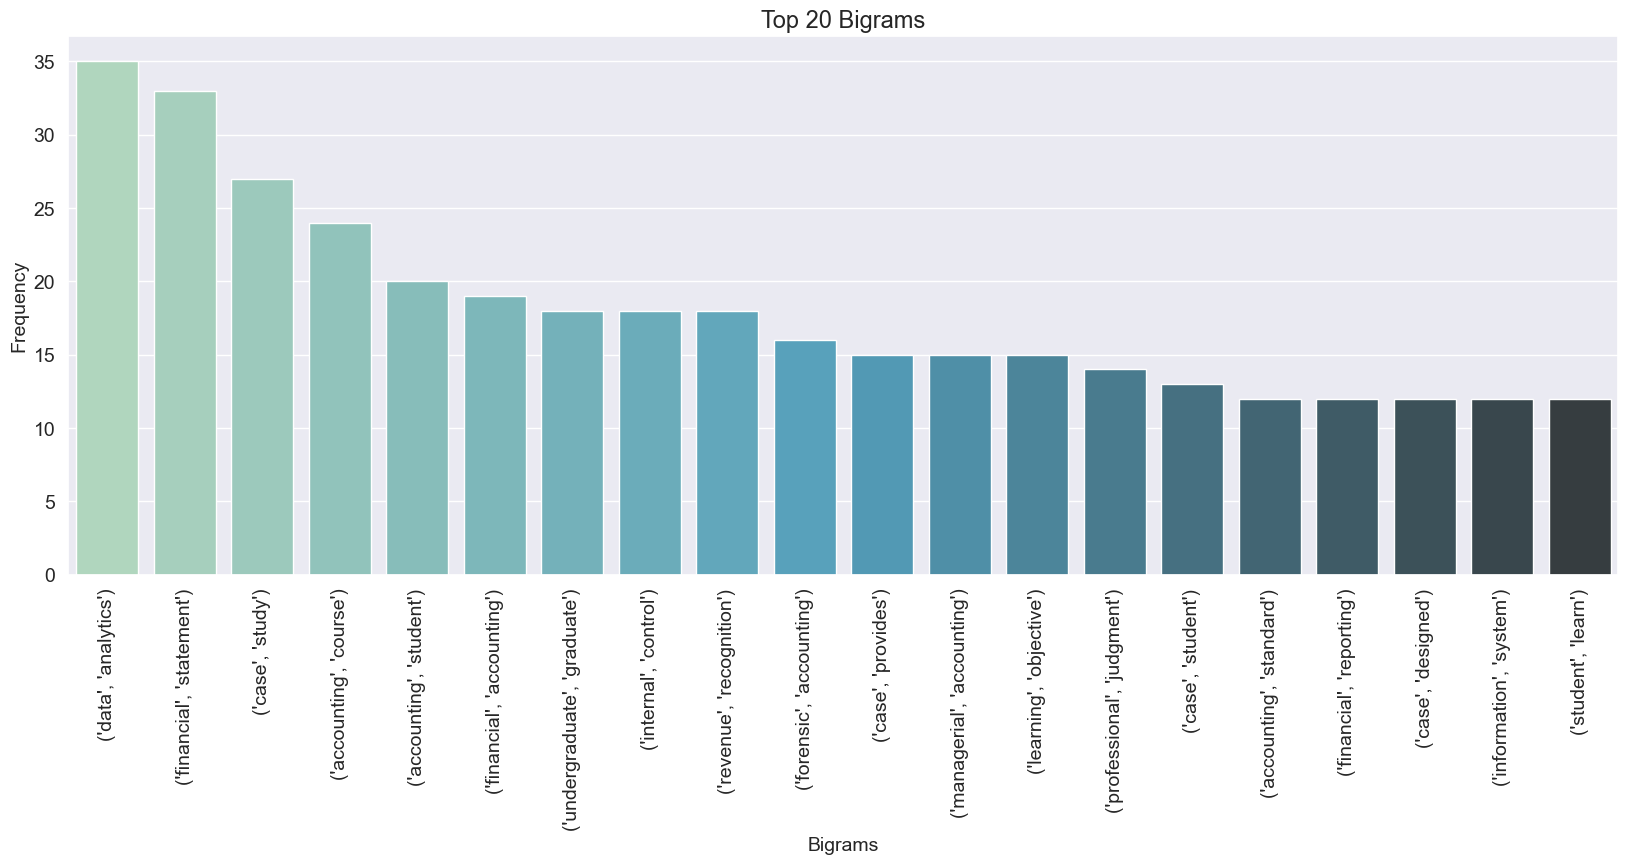

In [13]:
# Plot a bar chart for the top 20 most frequently occuring words
import seaborn as sns

fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='bigrams',
    y='frequency',
    data=s,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=90,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Bigrams', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Bigrams', fontsize=17)


fig.savefig('Top20-Bigrams.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

In [14]:
# Let's have a look at the 20 most frequent trigrams used in the cases
trigramseries = (pd.Series(nltk.ngrams(Abstract_list, 3)).value_counts())[:20]
t = trigramseries.to_frame()

t.reset_index(inplace=True)
t = t.rename(columns = {'index':'trigrams', 0: 'frequency'})
t

,trigrams,frequency
0,"(accounting, information, system)",9
1,"(case, introduces, student)",8
2,"(case, requires, student)",7
3,"(case, student, learn)",6
4,"(extract, transform, load)",6
5,"(case, help, student)",6
6,"(undergraduate, graduate, accounting)",5
7,"(written, communication, skill)",5
8,"(accounting, research, memo)",5
9,"(case, learning, objective)",5


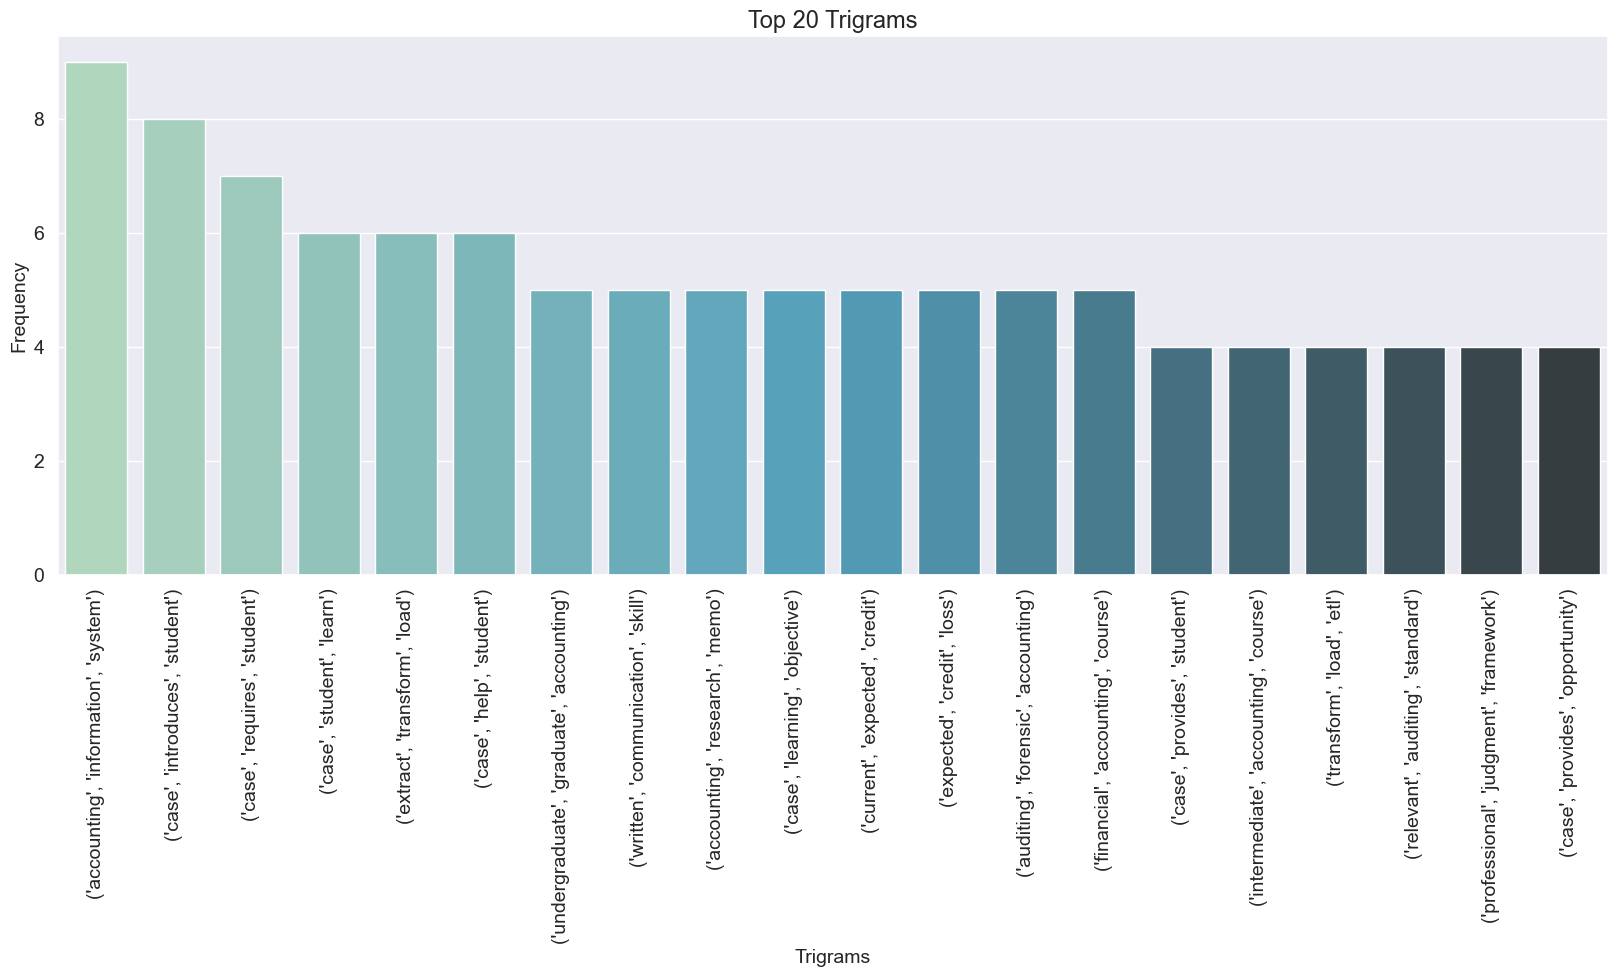

In [15]:
# Plot a bar chart for the top 20 most frequently occuring words
import seaborn as sns

fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='trigrams',
    y='frequency',
    data=t,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=90,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Trigrams', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Trigrams', fontsize=17)


fig.savefig('Top20-Tigrams.png',
    dpi=fig.dpi,
    bbox_inches='tight'
)

plt.show()

In [16]:
# Now let's feed the bigrams and trigrams back into the list of tokens 
# after filtering for unigrams
bigrams = s['bigrams'].tolist()
bi = []

for words in bigrams:
    bi2 = ' '.join(words)
    bi.append(bi2)
bi

['data analytics',
 'financial statement',
 'case study',
 'accounting course',
 'accounting student',
 'financial accounting',
 'undergraduate graduate',
 'internal control',
 'revenue recognition',
 'forensic accounting',
 'case provides',
 'managerial accounting',
 'learning objective',
 'professional judgment',
 'case student',
 'accounting standard',
 'financial reporting',
 'case designed',
 'information system',
 'student learn']

In [17]:
trigrams = t['trigrams'].tolist()
tri = []

for words in trigrams:
    tri2 = ' '.join(words)
    tri.append(tri2)
tri

['accounting information system',
 'case introduces student',
 'case requires student',
 'case student learn',
 'extract transform load',
 'case help student',
 'undergraduate graduate accounting',
 'written communication skill',
 'accounting research memo',
 'case learning objective',
 'current expected credit',
 'expected credit loss',
 'auditing forensic accounting',
 'financial accounting course',
 'case provides student',
 'intermediate accounting course',
 'transform load etl',
 'relevant auditing standard',
 'professional judgment framework',
 'case provides opportunity']

In [18]:
ngrams = bi+ tri

In [19]:
print(ngrams)

['data analytics', 'financial statement', 'case study', 'accounting course', 'accounting student', 'financial accounting', 'undergraduate graduate', 'internal control', 'revenue recognition', 'forensic accounting', 'case provides', 'managerial accounting', 'learning objective', 'professional judgment', 'case student', 'accounting standard', 'financial reporting', 'case designed', 'information system', 'student learn', 'accounting information system', 'case introduces student', 'case requires student', 'case student learn', 'extract transform load', 'case help student', 'undergraduate graduate accounting', 'written communication skill', 'accounting research memo', 'case learning objective', 'current expected credit', 'expected credit loss', 'auditing forensic accounting', 'financial accounting course', 'case provides student', 'intermediate accounting course', 'transform load etl', 'relevant auditing standard', 'professional judgment framework', 'case provides opportunity']


In [20]:
# Tags I want to remove from the text
removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM', 'VERB']
tokens = []

# Looping through text to tokenize the whole thing
for summary in nlp.pipe(reports['Abstract']):
    proj_tok = [token.lemma_.lower() for token in summary 
                if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    
   # unigrams = [token.lemma_.lower() for token in summary if token.pos_ not in removal and not token.is_stop and token.is_alpha]
   # proj_tok =
    
   # proj_tok = " ".join(unigrams)

    tokens.append(proj_tok)

In [21]:
i = 0
for summary in reports['Abstract']:
    for gram in ngrams:
        if gram in summary:
            tokens[i].append(gram)
    i = i+1        
tokens

[['student',
  'technique',
  'enron',
  'student',
  'exposure',
  'edrm',
  'student',
  'student',
  'student',
  'digitizing',
  'thought',
  'statement',
  'action',
  'forensic accounting',
  'case introduces student'],
 ['student',
  'relevant',
  'ifrs',
  'pressure',
  'cfo',
  'addition',
  'alternative',
  'action',
  'student',
  'accounting course',
  'financial accounting',
  'case requires student',
  'financial accounting course'],
 ['technology',
  'online',
  'cheating',
  'plentiful',
  'accessible',
  'technology',
  'easy',
  'technology',
  'prevention',
  'detection',
  'student',
  'educator',
  'perception'],
 ['technology', 'student', 'skill', 'information system'],
 ['access',
  'business',
  'competitive',
  'essential',
  'student',
  'practice',
  'datum',
  'management',
  'teamwork',
  'communication',
  'data analytics',
  'case designed'],
 ['change',
  'methodology',
  'student',
  'part',
  'documentation',
  'account',
  'document',
  'guideline',
 

In [22]:
reports['tokens'] = tokens
reports['tokens']

0      [student, technique, enron, student, exposure,...
1      [student, relevant, ifrs, pressure, cfo, addit...
2      [technology, online, cheating, plentiful, acce...
3       [technology, student, skill, information system]
4      [access, business, competitive, essential, stu...
                             ...                        
118    [student, director, director, business, studen...
119    [student, student, memo, asc, student, student...
120    [coso, student, example, digital, storytelling...
121    [datum, analytic, particular, analysis, method...
122    [wisconsin, exchange, subsidy, unfulfilled, fo...
Name: tokens, Length: 123, dtype: object

## Step 3: Create dictionary and corpus
The two main inputs to the LDA topic model are the dictionary and the corpus:
* Dictionary: The idea of the dictionary is to give each token a unique ID.
* Corpus: Having assigned a unique ID to each token, the corpus simply contains each ID and its frequency (if you wanna dive into it, then search for Bag of Word (BoW) which will introduce you to word embedding).

In [24]:
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(reports['tokens'])

In [25]:
#print(dictionary.token2id)
dict(list(dictionary.token2id.items())[:20])

{'action': 0,
 'case introduces student': 1,
 'digitizing': 2,
 'edrm': 3,
 'enron': 4,
 'exposure': 5,
 'forensic accounting': 6,
 'statement': 7,
 'student': 8,
 'technique': 9,
 'thought': 10,
 'accounting course': 11,
 'addition': 12,
 'alternative': 13,
 'case requires student': 14,
 'cfo': 15,
 'financial accounting': 16,
 'financial accounting course': 17,
 'ifrs': 18,
 'pressure': 19}

In the following, I will filter out low-frequency and high-frequency tokens, also limit the vocabulary to a max of 1000 words:
* No_below: Tokens that appear in less than 2 documents are filtered out.
* No_above: Tokens that appear in more than 60% of the total corpus are also removed as default.
* Keep_n: We limit ourselves to the top 1000 most frequent tokens (default is 100.000). Set to ‘None’ if you want to keep all.

In [26]:
dictionary.filter_extremes(no_below=2, no_above=0.6, keep_n=1000)

In [27]:
corpus = [dictionary.doc2bow(doc) for doc in reports['tokens']]

In [28]:
reports.head()

,Key,Item Type,Publication Year,Author,Title,Publication Title,ISBN,ISSN,DOI,Url,...,System,Code,Code Number,Section,Session,Committee,History,Legislative Body,Abstract,tokens
0,6I2EIXDA,journalArticle,2020.0,"Negangard, Eric M.; Fay, Rebecca G.",Electronic Discovery (eDiscovery): Performing ...,Issues in accounting education,NaN,"1558-7983, 0739-3172",10.2308/issues-16-064,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"A good investigator, whether it be in the cont...","[student, technique, enron, student, exposure,..."
1,F2PBB74H,journalArticle,2022.0,"Bremser, Wayne G.; Gullkvist, Benita M.","The Crusin Lines: Asset Impairment, Ethical Is...",Issues in Accounting Education,NaN,"1558-7983, 0739-3172",10.2308/ISSUES-19-107,http://ezproxy.library.dal.ca/login?url=https:...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A real-world incident inspired this instructio...,"[student, relevant, ifrs, pressure, cfo, addit..."
2,JPX3C6YU,journalArticle,2021.0,"Lux, Don; Knight, Margaret E.",Fighting Fire with Fire: Using Excel Macros to...,Issues in Accounting Education,NaN,"1558-7983, 0739-3172",10.2308/ISSUES-19-119,https://meridian.allenpress.com/iae/article/36...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Academic dishonesty is on the rise, and techno...","[technology, online, cheating, plentiful, acce..."
3,3MNDY4HS,journalArticle,2020.0,"Lee, Lorraine S.; Hansen, Victoria; Brink, Wil...",Tax Retirement Savings Decisions Using an Exce...,Issues in Accounting Education,NaN,"1558-7983, 0739-3172",10.2308/ISSUES-19-013,https://meridian.allenpress.com/iae/article/35...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accounting academia and professional organizat...,"[technology, student, skill, information system]"
4,BCWVRYVQ,journalArticle,2020.0,"Shawver, Tara J.; Shawver, Todd A.",Teaching Data Analytics in a Collaborative Tea...,Journal of Emerging Technologies in Accounting,NaN,"1558-7940, 1554-1908",10.2308/JETA-2020-029,https://meridian.allenpress.com/jeta/article/1...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accounting professionals have access to the da...,"[access, business, competitive, essential, stu..."


## Step 4: Selecting the Number of Topics
Now let's run the LDA Model over the dictionary and text for several different number of output topics and take a look at the topic coherence. This can be used to select an appropriate number of topics. More precisely, a range of different algorithms has been introduced to calculate the coherence score (C_v, C_p, C_uci, C_umass, C_npmi, C_a, …). In this notebook, we will implement the CV score.

In [29]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### CV Coherence Score
The coherence score for C_v ranges from 0 (complete incoherence) to 1 (complete coherence). According to McLevey (2021), values above 0.5 can be regarded as fairly good. However, the higher the average CV score, the better is the coherence of the number of topics (Sarkar 2019, Mishra 2022).

References:
* Mishra, M. (2022). Customer Experience: Extracting Topics From Tweets. International Journal of Market Research, 64(3), 334–353. https://doi.org/10.1177/14707853211047515
* Sarkar, D. (2019). Text Analytics with Python. In Text Analytics with Python. Apress. https://doi.org/10.1007/978-1-4842-4354-1
* McLevey, J. (2021). Doing Computational Social Science: A Practical Introduction. SAGE Publications.

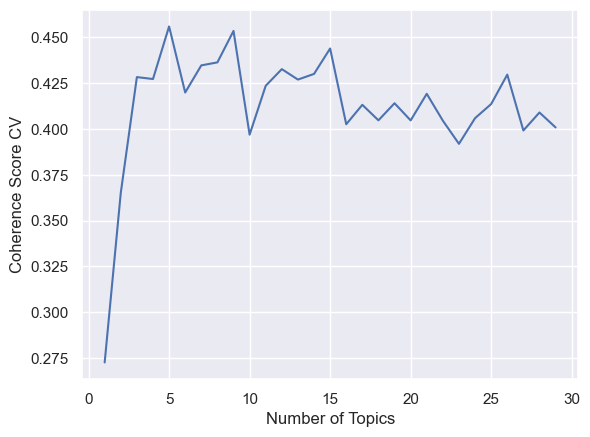

In [32]:
#Calculating the coherence score using C_v
topics_cv = []
score_cv = []
for i in range(1,30,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 8, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = reports['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics_cv.append(i)
   score_cv.append(cm.get_coherence())
_=plt.plot(topics_cv, score_cv)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score CV')
plt.show()

In [34]:
coherence_v = pd.DataFrame({'Number of Topics': topics_cv,
                               'Coherence Score': score_cv})
coherence_v['Sorted'] = coherence_v['Coherence Score'].abs()
coherence_v.sort_values(by=['Sorted'], ascending = False).head(10)

,Number of Topics,Coherence Score,Sorted
8,9,0.448790,0.448790
4,5,0.446906,0.446906
14,15,0.445001,0.445001
2,3,0.441947,0.441947
5,6,0.438758,0.438758
7,8,0.438273,0.438273
6,7,0.434919,0.434919
11,12,0.430353,0.430353
25,26,0.429658,0.429658
13,14,0.429102,0.429102


## Step 5: Running the Final Model
Adapting the model according to the optimal number of topics based on the calculated coherence scores. 
As in all three calculated score, the optimal number of topics seems to vary. In order to explore different facets of the phenomenon, we select a number of 5 topics since this seems to have fairly good coherence.

In [35]:
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, 
                         num_topics=9, workers = 8, passes=100)
# Choose 9 topics according to CV score

## Step 6: Extract, Add to Excel and Visualize the Topics
We can now print out the five topics and the related words:

In [36]:
lda_model.print_topics()

[(0,
  '0.051*"instructor" + 0.050*"managerial accounting" + 0.038*"information system" + 0.033*"technology" + 0.033*"accounting information system" + 0.027*"compliance" + 0.027*"business" + 0.027*"conclusion" + 0.023*"internal control" + 0.020*"asc"'),
 (1,
  '0.098*"auditing" + 0.041*"class" + 0.041*"control" + 0.037*"effective" + 0.022*"financial reporting" + 0.022*"canada" + 0.022*"available" + 0.022*"easy" + 0.022*"governance" + 0.022*"despite"'),
 (2,
  '0.070*"profit" + 0.068*"revenue" + 0.041*"organization" + 0.031*"company" + 0.031*"query" + 0.028*"auditor" + 0.023*"financial statement" + 0.021*"skill" + 0.021*"time" + 0.021*"individual"'),
 (3,
  '0.070*"accounting" + 0.066*"learning objective" + 0.043*"information" + 0.042*"objective" + 0.042*"ifrs" + 0.041*"accounting course" + 0.038*"data analytics" + 0.035*"instructor" + 0.034*"case learning objective" + 0.034*"financial accounting course"'),
 (4,
  '0.047*"use" + 0.043*"suitable" + 0.035*"accounting course" + 0.029*"case

In [37]:
from gensim import matutils

all_topics = lda_model.get_document_topics(corpus, minimum_probability=0.0)
all_topics_csr = matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)

In [38]:
merged = pd.merge(left=reports, left_index=True,
                  right=all_topics_df, right_index=True,
                  how='inner')
merged.head()

,Key,Item Type,Publication Year,Author,Title,Publication Title,ISBN,ISSN,DOI,Url,...,tokens,0,1,2,3,4,5,6,7,8
0,6I2EIXDA,journalArticle,2020.0,"Negangard, Eric M.; Fay, Rebecca G.",Electronic Discovery (eDiscovery): Performing ...,Issues in accounting education,NaN,"1558-7983, 0739-3172",10.2308/issues-16-064,NaN,...,"[student, technique, enron, student, exposure,...",0.015874,0.015881,0.015873,0.015878,0.015876,0.015875,0.015881,0.872981,0.015880
1,F2PBB74H,journalArticle,2022.0,"Bremser, Wayne G.; Gullkvist, Benita M.","The Crusin Lines: Asset Impairment, Ethical Is...",Issues in Accounting Education,NaN,"1558-7983, 0739-3172",10.2308/ISSUES-19-107,http://ezproxy.library.dal.ca/login?url=https:...,...,"[student, relevant, ifrs, pressure, cfo, addit...",0.012347,0.012346,0.012348,0.456809,0.012350,0.012346,0.456754,0.012352,0.012348
2,JPX3C6YU,journalArticle,2021.0,"Lux, Don; Knight, Margaret E.",Fighting Fire with Fire: Using Excel Macros to...,Issues in Accounting Education,NaN,"1558-7983, 0739-3172",10.2308/ISSUES-19-119,https://meridian.allenpress.com/iae/article/36...,...,"[technology, online, cheating, plentiful, acce...",0.888866,0.013894,0.013889,0.013889,0.013889,0.013896,0.013897,0.013889,0.013890
3,3MNDY4HS,journalArticle,2020.0,"Lee, Lorraine S.; Hansen, Victoria; Brink, Wil...",Tax Retirement Savings Decisions Using an Exce...,Issues in Accounting Education,NaN,"1558-7983, 0739-3172",10.2308/ISSUES-19-013,https://meridian.allenpress.com/iae/article/35...,...,"[technology, student, skill, information system]",0.467029,0.027778,0.027795,0.027782,0.027790,0.027778,0.338473,0.027793,0.027782
4,BCWVRYVQ,journalArticle,2020.0,"Shawver, Tara J.; Shawver, Todd A.",Teaching Data Analytics in a Collaborative Tea...,Journal of Emerging Technologies in Accounting,NaN,"1558-7940, 1554-1908",10.2308/JETA-2020-029,https://meridian.allenpress.com/jeta/article/1...,...,"[access, business, competitive, essential, stu...",0.012355,0.012346,0.012347,0.012350,0.012348,0.012350,0.012346,0.901210,0.012348


In [41]:
merged.to_excel("Merged LDA Probability_v2.xlsx")

In [45]:
list(merged.columns.values).index(0)

89

In [47]:
merged.iloc[:,89:98]

,0,1,2,3,4,5,6,7,8
0,0.015874,0.015881,0.015873,0.015878,0.015876,0.015875,0.015881,0.872981,0.015880
1,0.012347,0.012346,0.012348,0.456809,0.012350,0.012346,0.456754,0.012352,0.012348
2,0.888866,0.013894,0.013889,0.013889,0.013889,0.013896,0.013897,0.013889,0.013890
3,0.467029,0.027778,0.027795,0.027782,0.027790,0.027778,0.338473,0.027793,0.027782
4,0.012355,0.012346,0.012347,0.012350,0.012348,0.012350,0.012346,0.901210,0.012348
...,...,...,...,...,...,...,...,...,...
118,0.222178,0.022222,0.022229,0.022228,0.022224,0.022228,0.022222,0.022228,0.622240
119,0.822124,0.022223,0.022223,0.022250,0.022229,0.022227,0.022260,0.022232,0.022233
120,0.638862,0.013896,0.013889,0.263892,0.013891,0.013891,0.013894,0.013890,0.013894
121,0.011112,0.011112,0.011112,0.011112,0.011115,0.911100,0.011112,0.011113,0.011112


In [48]:
# first let's get the topic that is most probable for each abstract:
merged['Topic_ID'] = merged.iloc[:,89:98].idxmax(axis=1)
merged.iloc[:,89:99]

,0,1,2,3,4,5,6,7,8,Topic_ID
0,0.015874,0.015881,0.015873,0.015878,0.015876,0.015875,0.015881,0.872981,0.015880,7
1,0.012347,0.012346,0.012348,0.456809,0.012350,0.012346,0.456754,0.012352,0.012348,3
2,0.888866,0.013894,0.013889,0.013889,0.013889,0.013896,0.013897,0.013889,0.013890,0
3,0.467029,0.027778,0.027795,0.027782,0.027790,0.027778,0.338473,0.027793,0.027782,0
4,0.012355,0.012346,0.012347,0.012350,0.012348,0.012350,0.012346,0.901210,0.012348,7
...,...,...,...,...,...,...,...,...,...,...
118,0.222178,0.022222,0.022229,0.022228,0.022224,0.022228,0.022222,0.022228,0.622240,8
119,0.822124,0.022223,0.022223,0.022250,0.022229,0.022227,0.022260,0.022232,0.022233,0
120,0.638862,0.013896,0.013889,0.263892,0.013891,0.013891,0.013894,0.013890,0.013894,0
121,0.011112,0.011112,0.011112,0.011112,0.011115,0.911100,0.011112,0.011113,0.011112,5


In [43]:
list(merged.columns.values)

['Key',
 'Item Type',
 'Publication Year',
 'Author',
 'Title',
 'Publication Title',
 'ISBN',
 'ISSN',
 'DOI',
 'Url',
 'Abstract Note',
 'Date',
 'Date Added',
 'Date Modified',
 'Access Date',
 'Pages',
 'Num Pages',
 'Issue',
 'Volume',
 'Number Of Volumes',
 'Journal Abbreviation',
 'Short Title',
 'Series',
 'Series Number',
 'Series Text',
 'Series Title',
 'Publisher',
 'Place',
 'Language',
 'Rights',
 'Type',
 'Archive',
 'Archive Location',
 'Library Catalog',
 'Call Number',
 'Extra',
 'Notes',
 'File Attachments',
 'Link Attachments',
 'Manual Tags',
 'Automatic Tags',
 'Editor',
 'Series Editor',
 'Translator',
 'Contributor',
 'Attorney Agent',
 'Book Author',
 'Cast Member',
 'Commenter',
 'Composer',
 'Cosponsor',
 'Counsel',
 'Interviewer',
 'Producer',
 'Recipient',
 'Reviewed Author',
 'Scriptwriter',
 'Words By',
 'Guest',
 'Number',
 'Edition',
 'Running Time',
 'Scale',
 'Medium',
 'Artwork Size',
 'Filing Date',
 'Application Number',
 'Assignee',
 'Issuing Auth

In [49]:
topics_df = pd.DataFrame(list(lda_model.show_topics(formatted=False, num_words= 10)), columns = ["ID", "Topic_Prob"])
topics_df

,ID,Topic_Prob
0,0,"[(instructor, 0.050922435), (managerial accoun..."
1,1,"[(auditing, 0.09768718), (class, 0.04097272), ..."
2,2,"[(profit, 0.07042884), (revenue, 0.06792524), ..."
3,3,"[(accounting, 0.070495464), (learning objectiv..."
4,4,"[(use, 0.04690527), (suitable, 0.042808626), (..."
5,5,"[(data analytics, 0.061103974), (financial sta..."
6,6,"[(fraud, 0.061873697), (accounting student, 0...."
7,7,"[(accounting course, 0.037331756), (tableau, 0..."
8,8,"[(financial statement, 0.062481575), (inventor..."


In [50]:
data = lda_model.show_topics(formatted=True, num_words= 10)
data

[(0,
  '0.051*"instructor" + 0.050*"managerial accounting" + 0.038*"information system" + 0.033*"technology" + 0.033*"accounting information system" + 0.027*"compliance" + 0.027*"business" + 0.027*"conclusion" + 0.023*"internal control" + 0.020*"asc"'),
 (1,
  '0.098*"auditing" + 0.041*"class" + 0.041*"control" + 0.037*"effective" + 0.022*"financial reporting" + 0.022*"canada" + 0.022*"available" + 0.022*"easy" + 0.022*"governance" + 0.022*"despite"'),
 (2,
  '0.070*"profit" + 0.068*"revenue" + 0.041*"organization" + 0.031*"company" + 0.031*"query" + 0.028*"auditor" + 0.023*"financial statement" + 0.021*"skill" + 0.021*"time" + 0.021*"individual"'),
 (3,
  '0.070*"accounting" + 0.066*"learning objective" + 0.043*"information" + 0.042*"objective" + 0.042*"ifrs" + 0.041*"accounting course" + 0.038*"data analytics" + 0.035*"instructor" + 0.034*"case learning objective" + 0.034*"financial accounting course"'),
 (4,
  '0.047*"use" + 0.043*"suitable" + 0.035*"accounting course" + 0.029*"case

In [51]:
df = pd.DataFrame(data, columns = ['index', 'topics'])
df = df.replace('[^a-zA-Z+]', ' ', regex=True)
df

,index,topics
0,0,instructor + managerial account...
1,1,auditing + class + cont...
2,2,profit + revenue + orga...
3,3,accounting + learning objective...
4,4,use + suitable + accoun...
5,5,data analytics + financial stat...
6,6,fraud + accounting student + ...
7,7,accounting course + tableau + ...
8,8,financial statement + inventory...


In [52]:
df.iloc[2]['topics']

'       profit  +        revenue  +        organization  +        company  +        query  +        auditor  +        financial statement  +        skill  +        time  +        individual '

In [53]:
merged2 = merged
merged2["Topic Description"] = merged2["Topic_ID"]
for i in df['index']:
    merged2.loc[merged2['Topic_ID'] == i, 'Topic Description'] = df.iloc[i]['topics']

merged2

,Key,Item Type,Publication Year,Author,Title,Publication Title,ISBN,ISSN,DOI,Url,...,1,2,3,4,5,6,7,8,Topic_ID,Topic Description
0,6I2EIXDA,journalArticle,2020.0,"Negangard, Eric M.; Fay, Rebecca G.",Electronic Discovery (eDiscovery): Performing ...,Issues in accounting education,NaN,"1558-7983, 0739-3172",10.2308/issues-16-064,NaN,...,0.015881,0.015873,0.015878,0.015876,0.015875,0.015881,0.872981,0.015880,7,accounting course + tableau + ...
1,F2PBB74H,journalArticle,2022.0,"Bremser, Wayne G.; Gullkvist, Benita M.","The Crusin Lines: Asset Impairment, Ethical Is...",Issues in Accounting Education,NaN,"1558-7983, 0739-3172",10.2308/ISSUES-19-107,http://ezproxy.library.dal.ca/login?url=https:...,...,0.012346,0.012348,0.456809,0.012350,0.012346,0.456754,0.012352,0.012348,3,accounting + learning objective...
2,JPX3C6YU,journalArticle,2021.0,"Lux, Don; Knight, Margaret E.",Fighting Fire with Fire: Using Excel Macros to...,Issues in Accounting Education,NaN,"1558-7983, 0739-3172",10.2308/ISSUES-19-119,https://meridian.allenpress.com/iae/article/36...,...,0.013894,0.013889,0.013889,0.013889,0.013896,0.013897,0.013889,0.013890,0,instructor + managerial account...
3,3MNDY4HS,journalArticle,2020.0,"Lee, Lorraine S.; Hansen, Victoria; Brink, Wil...",Tax Retirement Savings Decisions Using an Exce...,Issues in Accounting Education,NaN,"1558-7983, 0739-3172",10.2308/ISSUES-19-013,https://meridian.allenpress.com/iae/article/35...,...,0.027778,0.027795,0.027782,0.027790,0.027778,0.338473,0.027793,0.027782,0,instructor + managerial account...
4,BCWVRYVQ,journalArticle,2020.0,"Shawver, Tara J.; Shawver, Todd A.",Teaching Data Analytics in a Collaborative Tea...,Journal of Emerging Technologies in Accounting,NaN,"1558-7940, 1554-1908",10.2308/JETA-2020-029,https://meridian.allenpress.com/jeta/article/1...,...,0.012346,0.012347,0.012350,0.012348,0.012350,0.012346,0.901210,0.012348,7,accounting course + tableau + ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,NaN,NaN,2020.0,"Brennan, Niamh M.","Directors' Responsibilities, Accountability, a...",Issues in Accounting Education,NaN,NaN,NaN,NaN,...,0.022222,0.022229,0.022228,0.022224,0.022228,0.022222,0.022228,0.622240,8,financial statement + inventory...
119,NaN,NaN,2022.0,"Huston, Janet M.; Samuels, Janet A.",Writing Accounting Research Memos: An Instruct...,Issues in Accounting Education,NaN,NaN,NaN,NaN,...,0.022223,0.022223,0.022250,0.022229,0.022227,0.022260,0.022232,0.022233,0,instructor + managerial account...
120,NaN,NaN,2022.0,"Douglass, Ashley; Farías Martínez, Gabriela Ma...",Bringing COSO to life: Engaging students with ...,Journal of Accounting Education,NaN,NaN,NaN,NaN,...,0.013896,0.013889,0.263892,0.013891,0.013891,0.013894,0.013890,0.013894,0,instructor + managerial account...
121,NaN,NaN,2022.0,"O'Leary, Daniel E.",Purchase order “analytic audit”,Journal of Emerging Technologies in Accounting,NaN,NaN,NaN,NaN,...,0.011112,0.011112,0.011112,0.011115,0.911100,0.011112,0.011113,0.011112,5,data analytics + financial stat...


In [54]:
merged2.to_excel('./AccPedagogy_LDATopicResults_v2.xlsx', index = True, header=True)

### Interactive Visualization of Topics with pyLDAvis
The above chart represents our five topics as circles. They have been drawn using a dimensionality reduction technique called PCA. The goal is to have a distance in order to avoid overlapping and make each circle unique. When I hover over a circle different words are displayed on the right, showing word frequency (blue) and estimated term frequency within the selected topic (red). Topics closer to each other are more related.

In [55]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

/Users/anikanissen/opt/anaconda3/envs/LDAVirtualInfluencers/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/Users/anikanissen/opt/anaconda3/envs/LDAVirtualInfluencers/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/anikanissen/opt/anaconda3/envs/LDAVirtualInfluencers/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/anikanissen/opt/anaconda3/envs/LDAVirtualInfluencers/lib/python3.10/site-packa

In [56]:
# Save the report
pyLDAvis.save_html(lda_display, 'LDA_VIS_AccPedagogy.html')